# Creating statistics and maps of street designations for communes

## Load libraries and data

In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import time
import pysal as ps
from legendgram import legendgram
import esda

%matplotlib inline

In [2]:
%%time 

# Street name designations
streetnames = pd.read_csv('../Datapreparation/streetnames.csv', encoding='UTF-8-SIG', sep=';')

# Specific street name designations
streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)

# Communes data
com = pd.read_csv('data/gmde_info.csv', encoding='UTF-8-SIG', sep=';')

# Communes geometries
com_geom = geopandas.read_file('data/gemeinden.geojson')

# Communes geometries only de and fr communes (it and rom removed)
com_geom_de_fr = geopandas.read_file('data/gemeinden_de_fr.geojson')

# Create dataset with all information on commune level
communes = pd.merge(com_geom, com, on=['GMDNR'], how='outer')

communes_de_fr = pd.merge(com_geom_de_fr, com, on=['GMDNR'], how='left')

CPU times: total: 3.59 s
Wall time: 3.81 s


## Mapping most common generic street term per commune

In [3]:
#get most common generic street designation per commune
commune_top_term = streetnames_s.groupby(['COM_FOSNR'])['STR_TERMS'].agg(pd.Series.mode).to_frame()

In [4]:
commune_top_term.STR_TERMS.apply(lambda x: str(x)).unique()

array(['weg', 'strasse', 'wäg', "['strasse' 'weg']", '[]', 'chemin',
       'rue', 'route', "['gasse' 'weg']", "['impasse' 'route']",
       'impasse', "['chemin' 'rue']", "['chemin' 'route']", 'gasse',
       "['steg' 'strasse']", "['steg' 'weg']", 'allee', 'platz', 'voa',
       'voia', 'veia', 'via', 'vietta', 'strada', 'ruelle',
       "['chemin' 'route' 'rue']", "['route' 'rue']",
       "['route' 'ruelle']", "['chemin' 'gasse' 'route' 'rue' 'ruelle']"],
      dtype=object)

In [5]:
#There are multiple mode for some communes, we only keep the first one.
commune_top_term['STR_TERMS'] = commune_top_term['STR_TERMS'].str.replace("(' ').*","", regex=True)

In [6]:
commune_top_term.STR_TERMS.apply(lambda x: str(x)).unique()

array(['weg', 'strasse', 'wäg', 'nan', 'chemin', 'rue', 'route',
       'impasse', 'gasse', 'allee', 'platz', 'voa', 'voia', 'veia', 'via',
       'vietta', 'strada', 'ruelle'], dtype=object)

In [7]:
streetnames_s['classif'] = streetnames_s['classif'].replace('Andere', np.NaN)

In [8]:
commune_top_term_s = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.mode).to_frame()

In [9]:
commune_top_term_s.classif.apply(lambda x: str(x)).unique()

array(['Natur', "['Natur' 'Siedlung']", 'Siedlung', 'Lebewesen',
       'Ortschaft', '[]',
       "['Gewässer' 'Lebewesen' 'Person' 'Religion' 'Siedlung']",
       'Person', "['Lebewesen' 'Siedlung']", "['Natur' 'Ortschaft']",
       "['Berg' 'Lebewesen']", "['Berg' 'Natur']",
       "['Natur' 'Ortschaft' 'Siedlung']",
       "['Lebewesen' 'Ortschaft' 'Person' 'Religion']",
       "['Ortschaft' 'Siedlung']", "['Ortschaft' 'Person']",
       "['Person' 'Siedlung']", "['Lebewesen' 'Natur' 'Ortschaft']",
       "['Gewässer' 'Siedlung']", "['Lebewesen' 'Natur' 'Person']",
       "['Lebewesen' 'Natur']", 'Gewässer', 'Berg',
       "['Lebewesen' 'Ortschaft' 'Siedlung']",
       "['Berg' 'Gewässer' 'Natur' 'Siedlung']",
       "['Lebewesen' 'Ortschaft' 'Person' 'Siedlung']",
       "['Ortschaft' 'Person' 'Siedlung']",
       "['Natur' 'Ortschaft' 'Person' 'Siedlung']",
       "['Ortschaft' 'Religion']", "['Berg' 'Ortschaft']",
       "['Berg' 'Natur' 'Ortschaft' 'Siedlung']",
       "['Gewäss

In [10]:
#There are multiple mode for some communes, we only keep the first one.
commune_top_term_s['classif'] = commune_top_term_s['classif'].str.replace("(' ').*","", regex=True)

In [11]:
commune_top_term_s.classif.apply(lambda x: str(x)).unique()

array(['Natur', 'nan', 'Siedlung', 'Lebewesen', 'Ortschaft', 'Person',
       'Gewässer', 'Berg', 'Religion'], dtype=object)

In [12]:
communes = pd.merge(communes, commune_top_term, left_on='GMDNR', right_on='COM_FOSNR', how='outer')
communes_de_fr = pd.merge(communes_de_fr, commune_top_term, left_on='GMDNR', right_on='COM_FOSNR', how='left')

In [13]:
communes = pd.merge(communes, commune_top_term_s, left_on='GMDNR', right_on='COM_FOSNR', how='outer')
communes_de_fr = pd.merge(communes_de_fr, commune_top_term_s, left_on='GMDNR', right_on='COM_FOSNR', how='left')

In [14]:
communes.columns

Index(['FID', 'GMDHISTID_x', 'GMDNR', 'GMDNAME_x', 'BZHISTID_x', 'BZNR_x',
       'KTNR_x', 'GRNR_x', 'AREA_HA_x', 'E_MIN', 'E_MAX', 'N_MIN', 'N_MAX',
       'E_CNTR_x', 'N_CNTR_x', 'Z_MIN', 'Z_MAX', 'Z_AVG', 'Z_MED', 'Z_CNTR_x',
       'geometry', 'GMDHISTID_y', 'GMDNAME_y', 'BZHISTID_y', 'BZNR_y',
       'KTNR_y', 'GRNR_y', 'AREA_HA_y', 'E_CNTR_y', 'N_CNTR_y', 'Z_CNTR_y',
       'GMD_STR_LENGTH', 'STR_TERMS', 'classif'],
      dtype='object')

In [15]:
communes.plot(column='GMD_STR_LENGTH', figsize=(10, 6))
plt.axis('off')

(2468003.35, 2851257.65, 1064234.8020000015, 1306970.712999999)

In [16]:
communes['STR_TERMS'] = communes['STR_TERMS'].fillna('other')

In [17]:
communes['STR_TERMS'].apply(lambda x: str(x)).unique()

array(['strasse', 'via', 'weg', 'wäg', 'other', 'chemin', 'rue', 'route',
       'impasse', 'gasse', 'allee', 'platz', 'voa', 'voia', 'veia',
       'vietta', 'strada', 'ruelle'], dtype=object)

In [18]:
colors = {
    'allee': '#01665e',
    'chemin': '#cab2d6',
    'gasse': '#1f78b4',
    'impasse': '#e31a1c',
    'platz': '#35978f',
    'route': '#fb9a99',
    'rue': '#b2df8a',
    'ruelle': '#33a02c',
    'strada': '#ffff33',
    'strasse': '#a6cee3',
    'veia': '#f1b6da',
    'via': '#fee08b',
    'vietta': '#762a83',
    'voa': '#c51b7d',
    'voia': '#8c510a',
    'wäg': '#ff7f00',
    'weg': '#fdbf6f',
    'other': '#d9d9d9',
}


In [19]:
f, ax = plt.subplots(1, figsize=(13,13))
    
    
communes.plot(ax=ax, 
                        color=[colors[d] for d in communes.STR_TERMS])


plt.axis('off')

plt.legend(handles=[mpatches.Patch(color=colors[k],
                label=k) for k in colors],
               loc='center right',
               fontsize='small',
               edgecolor='none',
               title='top street term',
               title_fontsize='large',
               bbox_to_anchor=(1.1, 0.5))

## Mapping ratio of named streets (vs streets without name)

In [20]:
# Street name geometries
streets_geom = geopandas.read_file('data/pure_line.geojson')

In [21]:
# Create dataset with all information on street level
streetnames_geom = pd.merge(streets_geom, streetnames, on=['STR_ESID','STR_ESID'], how='outer')

In [22]:
streetnames_length_comm = streetnames_geom.dissolve(by='COM_FOSNR', aggfunc={
         "LENGTH": "sum",
         "COM_NAME": "first",
         "COM_FOSNR": "first"    
     })

In [23]:
streetnames_length_comm.columns

Index(['geometry', 'LENGTH', 'COM_NAME', 'COM_FOSNR'], dtype='object')

In [24]:
# to remove ambiguity error
streetnames_length_comm.rename(columns = {'COM_FOSNR':'FOSNR'}, inplace = True)

In [25]:
#now we have per commune street length AND streetname length
communes_length = pd.merge(communes, streetnames_length_comm, left_on='GMDNR', right_on='COM_FOSNR', how='outer')

In [26]:
communes_length.LENGTH = communes_length.LENGTH/1000

In [27]:
communes_length = communes_length.assign(ratioNamed = communes_length.LENGTH/communes_length.GMD_STR_LENGTH)

In [28]:
# to remove ambiguity error
communes_length.rename(columns = {'geometry_x':'geometry'}, inplace = True)

In [29]:
communes_length['ratioNamed'] = communes_length['ratioNamed'].fillna('0')

In [30]:
communes_length['ratioNamed'] = communes_length['ratioNamed'].astype(str).astype(float)

Text(0.5, 1.0, 'Verhältnis benannte vs. unbenannte Strassen')

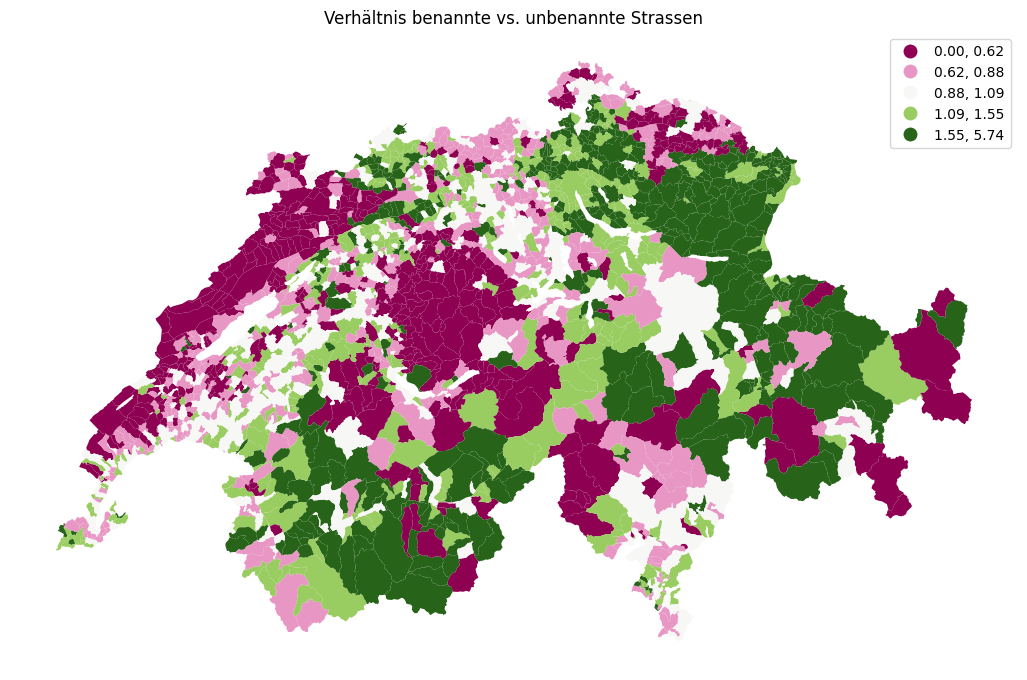

In [31]:
f, ax = plt.subplots(1, figsize=(13,13))
    
    
communes_length.plot(column='ratioNamed', 
                     cmap='PiYG', 
                     figsize=(10, 6), 
                     ax=ax, 
                     legend=True,
                     scheme='quantiles')

plt.axis('off')
plt.title("Verhältnis benannte vs. unbenannte Strassen")

# Mapping most common specific street term per commune

In [32]:
communes_de_fr['classif'] = communes_de_fr['classif'].fillna('no_value')

In [33]:
communes_de_fr['classif'].apply(lambda x: str(x)).unique()

array(['Natur', 'no_value', 'Siedlung', 'Lebewesen', 'Ortschaft',
       'Person', 'Gewässer', 'Berg'], dtype=object)

In [34]:
colors = {
    'Ortschaft': '#e41a1c',
    'Natur': '#4daf4a',
    'Gewässer': '#1f78b4',
    'Lebewesen': '#984ea3',
    'Siedlung': '#ff7f00',
    'Person': '#ffff33',
    'Berg': '#a65628',
    'Religion': '#f781bf',
    #'Andere' : '#fee08b',
    'no_value': '#d9d9d9',
}

In [35]:
communes_de_fr

FID  GMDHISTID_x  GMDNR           GMDNAME_x  BZHISTID_x  BZNR_x  \
0        0        16620   3112       Schwende-Rüte       10252    1600   
1        2        13256      1     Aeugst am Albis       10053     101   
2        3        11742      2  Affoltern am Albis       10053     101   
3        4        11801      3          Bonstetten       10053     101   
4        5        11992      4     Hausen am Albis       10053     101   
...    ...          ...    ...                 ...         ...     ...   
1992  2143        13353   6806        Vendlincourt       10226    2603   
1993  2144        14970   6807       Basse-Allaine       10226    2603   
1994  2145        14965   6808       Clos du Doubs       10226    2603   
1995  2146        16120   6809         Haute-Ajoie       10226    2603   
1996  2147        14969   6810          La Baroche       10226    2603   

      KTNR_x  GRNR_x  AREA_HA_x    E_MIN  ...  BZNR_y  KTNR_y  GRNR_y  \
0         16       5       9833  2742569  ...    1600      16       5   
1          1       4        791  2678111  ...     101       1       4   
2          1       4       1059  2673826  ...     101       1       4   
3          1       4        743  2675745  ...     101       1       4   
4          1       4       1360  2680394  ...     101       1       4   
...      ...     ...        ...      ...  ...     ...     ...     ...   
1992      26       2        915  2575722  ...    2603      26       2   
1993      26       2       2304  2566914  ...    2603      26       2   
1994      26       2       6175  2569448  ...    2603      26       2   
1995      26       2       4093  2557722  ...    2603      26       2   
1996      26       2       3107  2578224  ...    2603      26       2   

      AREA_HA_y  E_CNTR_y  N_CNTR_y  Z_CNTR_y  GMD_STR_LENGTH  STR_TERMS  \
0          9833   2750500   1243000       799      108.036588    strasse   
1           791   2679300   1235700       700       26.516156        weg   
2          1059   2676800   1236800       490       66.711839    strasse   
3           743   2677800   1241000       544       31.501571    strasse   
4          1360   2682900   1233100       610       42.495957    strasse   
...         ...       ...       ...       ...             ...        ...   
1992        915   2578200   1255600       441       19.431732      route   
1993       2304   2569300   1258900       385       46.657442      route   
1994       6175   2579100   1246300       449      101.283739     chemin   
1995       4093   2567000   1249100       492       64.072282        rue   
1996       3107   2582400   1252500       523       43.076611     chemin   

        classif  
0         Natur  
1         Natur  
2         Natur  
3         Natur  
4         Natur  
...         ...  
1992   no_value  
1993  Ortschaft  
1994     Person  
1995  Ortschaft  
1996  Ortschaft  

[1997 rows x 35 columns]

In [36]:
f, ax = plt.subplots(1, figsize=(13,13))
    
communes.plot(figsize=(13,13),ax=ax, color = 'silver')
communes_de_fr.plot(ax=ax, 
                        color=[colors[d] for d in communes_de_fr.classif])


plt.axis('off')

plt.legend(handles=[mpatches.Patch(color=colors[k],
                label=k) for k in colors],
               loc='center right',
               fontsize='small',
               edgecolor='none',
               title='top category',
               title_fontsize='large',
               bbox_to_anchor=(1.1, 0.5))



## Mapping percent of common specific street term per commune

In [37]:
streetnames_s.groupby(['COM_FOSNR', 'classif']).size().to_frame()

0
COM_FOSNR classif      
1.0       Berg        7
          Gewässer    3
          Lebewesen   1
          Natur      15
          Ortschaft   6
...                  ..
6810.0    Lebewesen   2
          Ortschaft  16
          Person      4
          Religion    1
          Siedlung   11

[13927 rows x 1 columns]

In [38]:
kategorie = 'Person'

subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

In [39]:
alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

In [40]:
kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

In [41]:
kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)
kategorie_merge

classif_x  classif_y  percent_subset
COM_FOSNR                                      
1.0                2         45        4.444444
2.0                5        142        3.521127
3.0                9         88       10.227273
4.0                8        117        6.837607
5.0                6        111        5.405405
...              ...        ...             ...
6806.0             4         17       23.529412
6807.0             6         33       18.181818
6808.0            11         34       32.352941
6809.0             6         28       21.428571
6810.0             4         37       10.810811

[2082 rows x 3 columns]

In [42]:
communes_kategorie = pd.merge(communes, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='outer')
communes_kategorie = communes_kategorie.fillna(0)

In [43]:
import mapclassify as mc
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=9).bins
bins

array([ 0.        ,  2.56410256,  4.59418609,  6.7882212 ,  9.09090909,
       12.5       , 18.835176  , 29.09199522, 87.5       ])

Text(0.5, 0, '% Kategorie: Person')

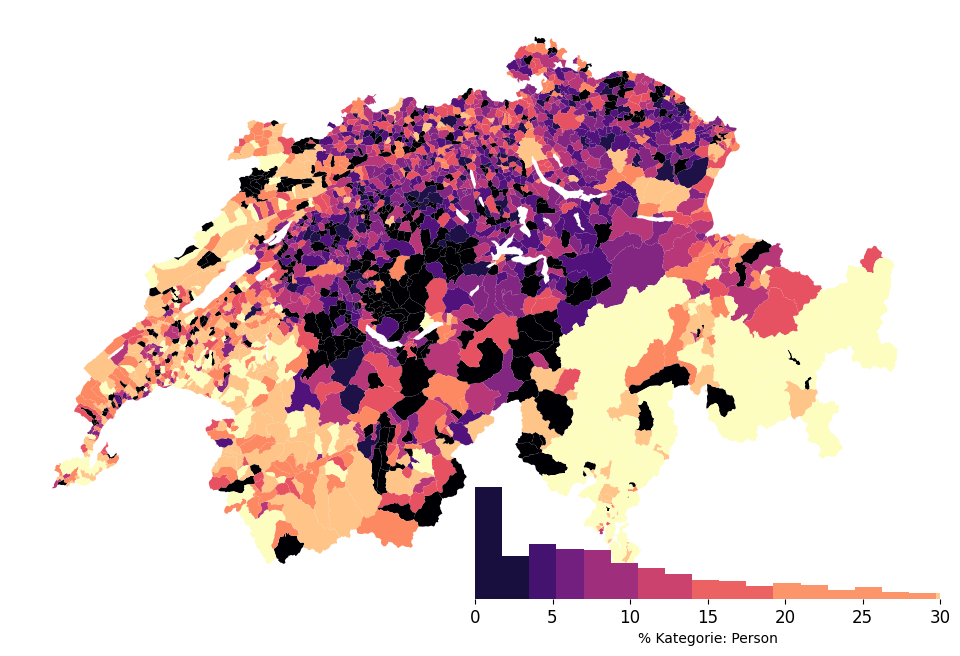

In [44]:
import palettable.matplotlib as palmpl
import mapclassify as mc

f,ax = plt.subplots(1, figsize=(12,12))
communes_kategorie.plot('percent_subset', k=9, ax=ax, cmap='magma', scheme='Quantiles')

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=9).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Magma_9,
           legend_size=(.5,.2), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,30) # clip the displayed range of the histogram
           )


xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

In [73]:
kategorie = 'Person'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=10
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_10,
           legend_size=(.4,.4), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,20) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

Text(0.5, 0, '% Kategorie: Person')

In [46]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran


trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

#gdf = gdf[gdf.classif_y > 10]


#gdf.loc[gdf['classif_y'] < 10, 'percent_subset'] = gdf['percent_subset'].mean()

#gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.01, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

In [47]:
print(gdf[gdf['GMDNAME'].str.contains('Entlebuch')])



     FID_x  GMDHISTID  GMDNR    GMDNAME  BZHISTID  BZNR  KTNR  GRNR  AREA_HA  \
503    503      15561   1002  Entlebuch     10303   316     3     6     5690   

     E_MIN_x  ...  AREA_HA_y   E_CNTR_y   N_CNTR_y  Z_CNTR_y  GMD_STR_LENGTH  \
503  2643451  ...     5690.0  2647600.0  1204800.0     722.0       96.967789   

     STR_TERMS  classif  classif_x  classif_y  percent_subset  
503    strasse    Natur        0.0       49.0             0.0  

[1 rows x 57 columns]


Text(0.5, 0, '% Kategorie: Siedlung')

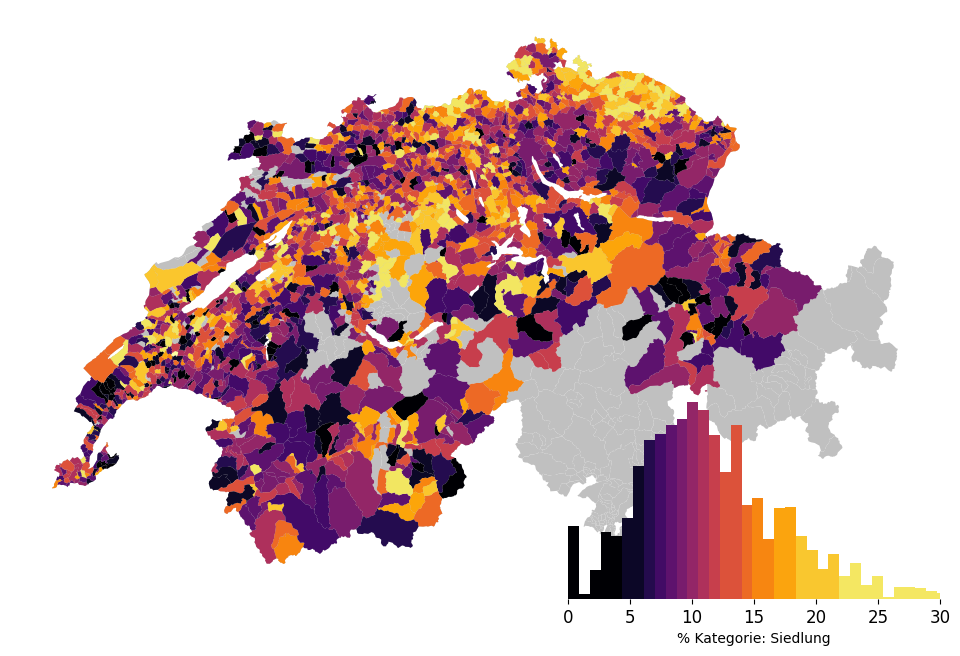

In [85]:
kategorie = 'Siedlung'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=15
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_15,
           legend_size=(.4,.35), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,30) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

In [49]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran


trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

#gdf = gdf[gdf.classif_y > 10]


#gdf.loc[gdf['classif_y'] < 10, 'percent_subset'] = gdf['percent_subset'].mean()

#gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.01, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Ortschaft')

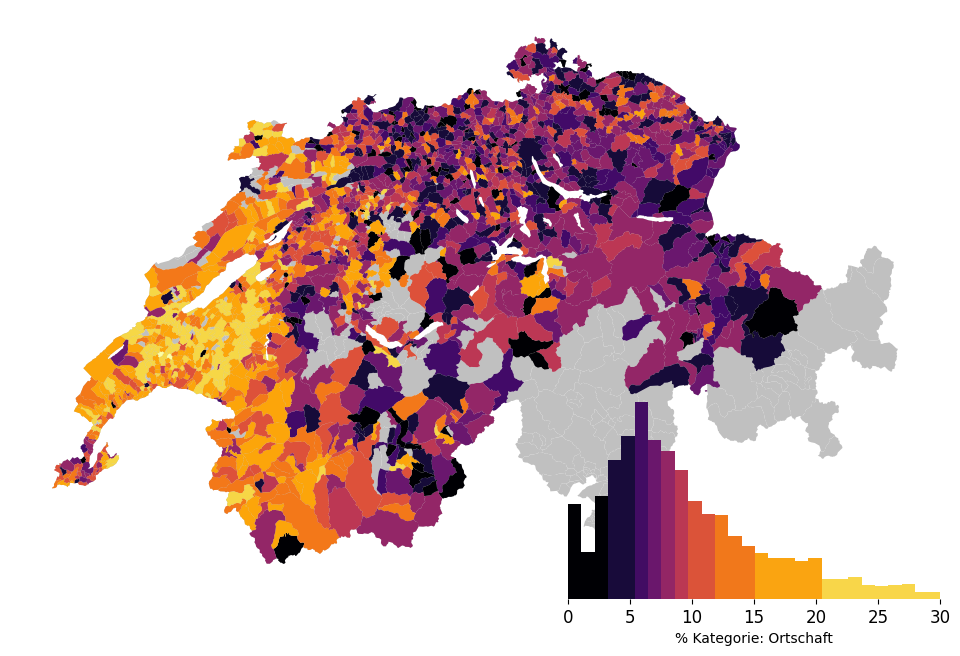

In [69]:
kategorie = 'Ortschaft'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=10
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_10,
           legend_size=(.4,.35), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,30) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

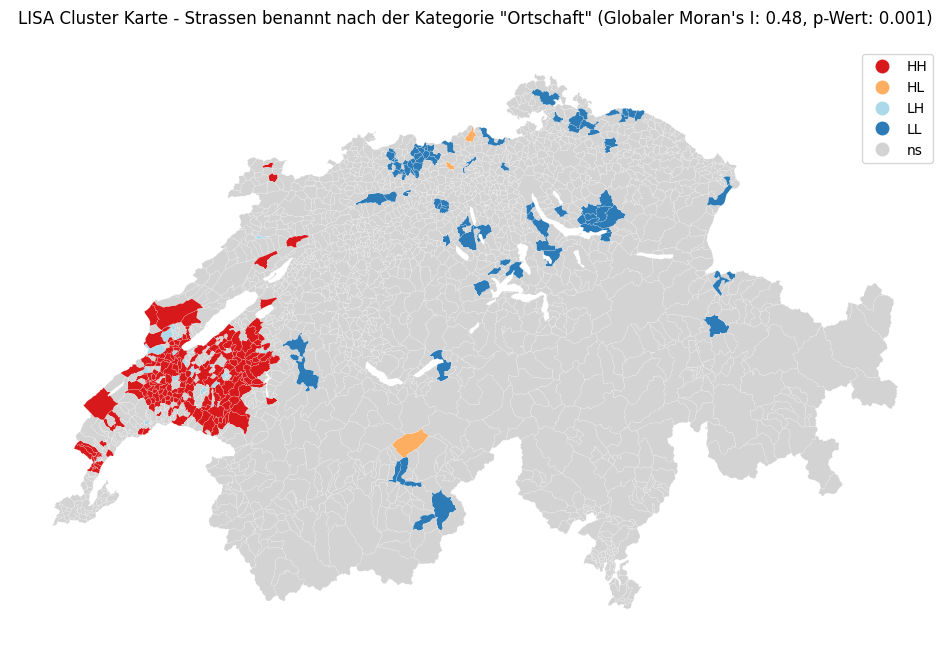

In [51]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran


trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

#gdf = gdf[gdf.classif_y > 10]


#gdf.loc[gdf['classif_y'] < 10, 'percent_subset'] = gdf['percent_subset'].mean()

#gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.01, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Gewässer')

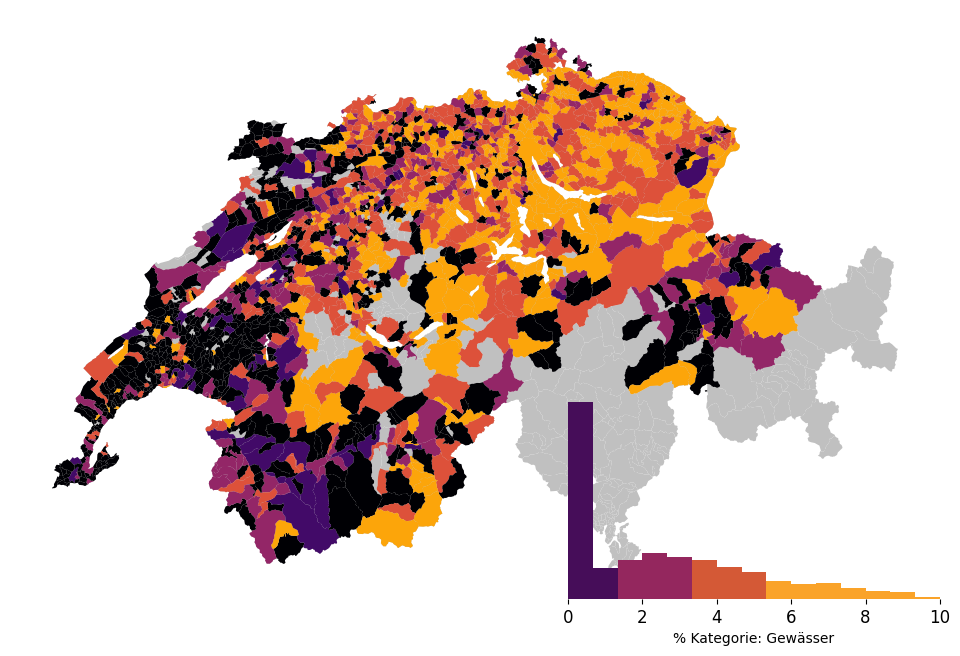

In [52]:
kategorie = 'Gewässer'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=5
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_5,
           legend_size=(.4,.35), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,10) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

In [74]:
communes_kategorie.sort_values(by='percent_subset', ascending=False).head(50)

FID  GMDHISTID_x  GMDNR             GMDNAME_x  BZHISTID_x  BZNR_x  \
1541  1692        14732   5560            Grandevent       10276    2224   
1116  1118        16085   3544        Bergün Filisur       10307    1841   
1112  1113        15962   3506           Vaz/Obervaz       10307    1841   
1672  1823        14792   5785    Corcelles-le-Jorat       10274    2222   
1504  1655        14668   5493                  Orny       10279    2227   
1472  1623        14624   5429              Longirod       10280    2228   
719    720        10906   2155               Vaulruz       10105    1003   
1929  2080        12484   6631                  Onex       10187    2500   
1897  2048        16117   6511         Les Verrières       10320    2400   
1919  2070        12099   6621                Genève       10187    2500   
250    251        15092    441            Renan (BE)       10283     241   
1911  2062        11535   6613           Chêne-Bourg       10187    2500   
1910  2061        11431   6612       Chêne-Bougeries       10187    2500   
731    732        12060   2197              Givisiez       10104    1004   
1493  1644        14716   5482              Eclépens       10279    2227   
674    675        10944   2045                Vallon       10107    1001   
1742  1893        14878   5931          Treycovagnes       10276    2224   
1605  1756        14698   5673            Hermenches       10274    2222   
254    255        15096    445             Sonvilier       10283     241   
1969  2120        13308   6750           Lajoux (JU)       10225    2602   
1884  2035        16605   6436              Le Locle       10320    2400   
1939  2090        10896   6641               Troinex       10187    2500   
1143  1152        15997   3732                 Flims       10310    1844   
1555  1706        14649   5586              Lausanne       10277    2225   
1586  1737        14637   5640      Lussy-sur-Morges       10279    2227   
1587  1738        14690   5642                Morges       10279    2227   
253    254        15095    444     Sonceboz-Sombeval       10283     241   
1802  1953        10891   6142                Trient       10029    2307   
730    731        11954   2196              Fribourg       10104    1004   
1488  1639        14814   5476              Chevilly       10279    2227   
1515  1666        14772   5515  Bretigny-sur-Morrens       10275    2223   
1680  1831        15687   5806        Jorat-Mézières       10278    2226   
1865  2016        10574   6294           Staldenried       10180    2313   
1096  1097        14450   3394               Mosnang       10264    1727   
256    257        15099    448              Villeret       10283     241   
1453  1604        14793   5404            Corbeyrier       10273    2221   
1474  1625        14679   5431          Mollens (VD)       10279    2227   
1877  2028        16095   6421     La Chaux-de-Fonds       10320    2400   
1119  1127        16061   3619           Ilanz/Glion       10316    1850   
1712  1863        14802   5883              Corseaux       10282    2230   
1521  1672        14748   5523           Froideville       10275    2223   
1677  1828        14902   5803              Vulliens       10274    2222   
698    699        14362   2121         Haut-Intyamon       10105    1003   
1563  1714        14753   5604        Forel (Lavaux)       10278    2226   
1374  1418        15404   4421                  Horn       10293    2011   
1800  1951        12871   6140               Saillon       10029    2307   
1581  1732        14721   5635         Ecublens (VD)       10281    2229   
1240  1284        13161   4110               Remigen       10023    1904   
1536  1687        14798   5554               Concise       10276    2224   
1994  2145        14965   6808         Clos du Doubs       10226    2603   

      KTNR_x  GRNR_x  AREA_HA_x    E_MIN  ...  AREA_HA_y  E_CNTR_y  N_CNTR_y  \
1541      22       1        344  2534299  ...     

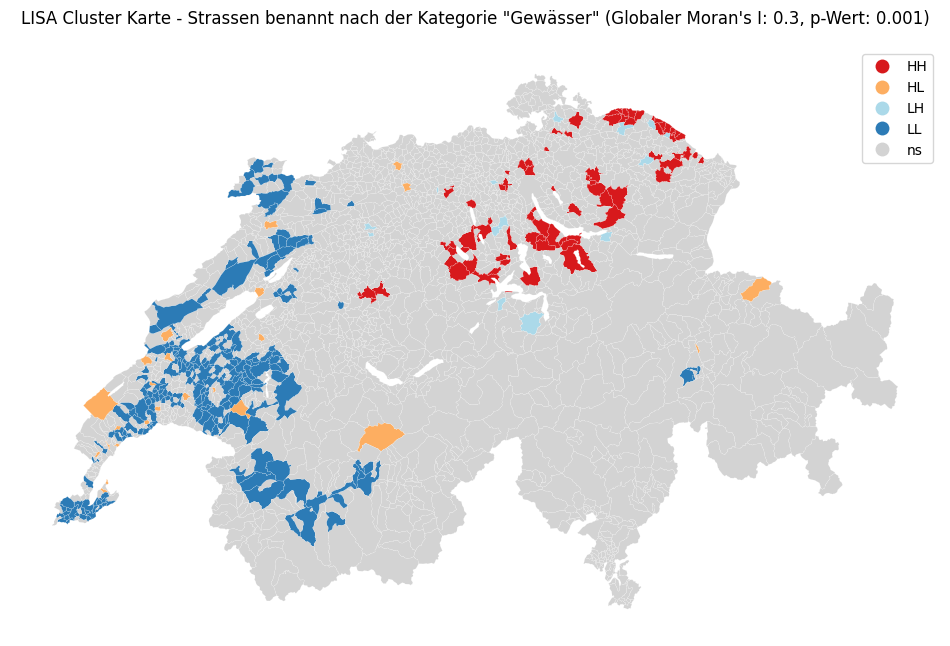

In [54]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran


trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

#gdf = gdf[gdf.classif_y > 10]


#gdf.loc[gdf['classif_y'] < 10, 'percent_subset'] = gdf['percent_subset'].mean()

#gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.02, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Berg')

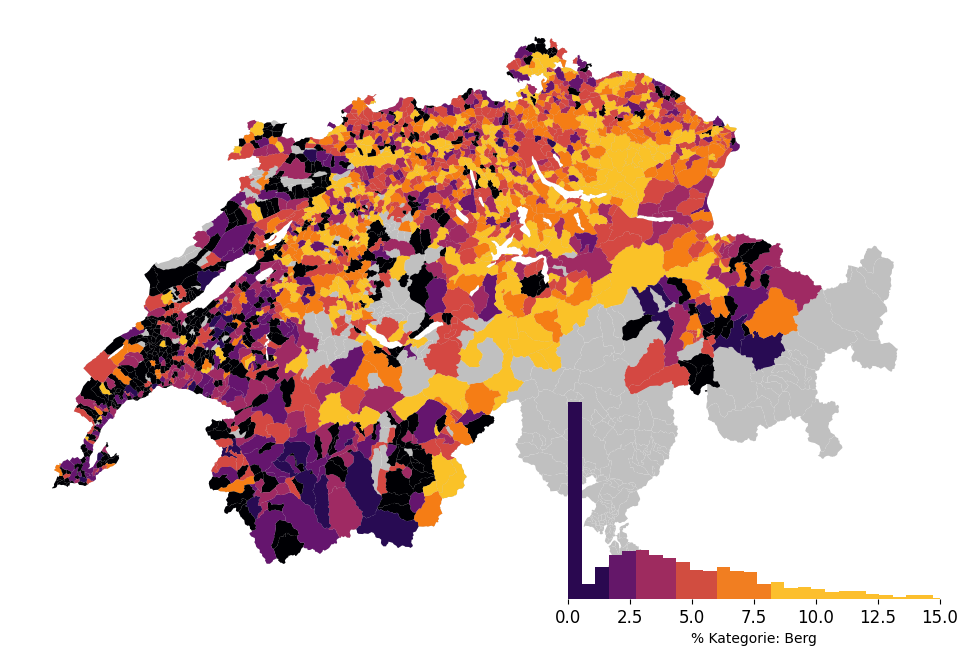

In [55]:
kategorie = 'Berg'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=7
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_7,
           legend_size=(.4,.35), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,15) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

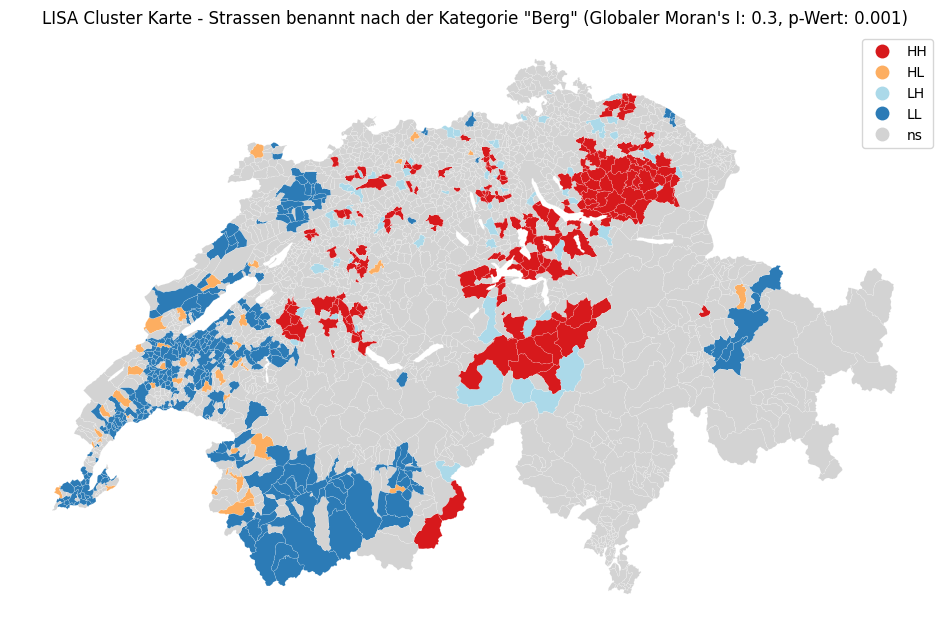

In [56]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran


trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

#gdf = gdf[gdf.classif_y > 10]


#gdf.loc[gdf['classif_y'] < 10, 'percent_subset'] = gdf['percent_subset'].mean()

#gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.05, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Religion')

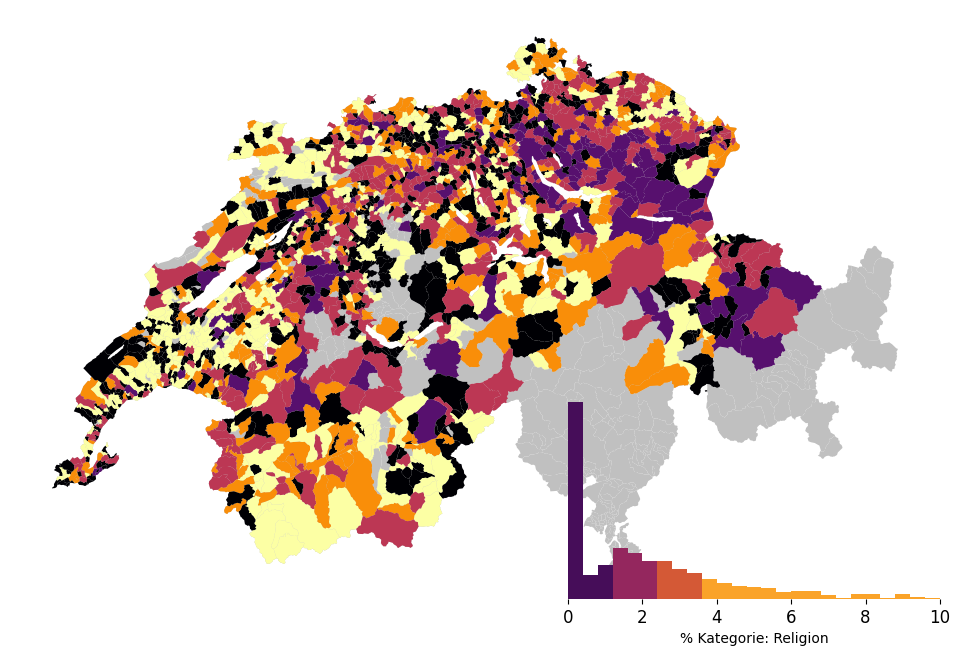

In [57]:
kategorie = 'Religion'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=5
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_5,
           legend_size=(.4,.35), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,10) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

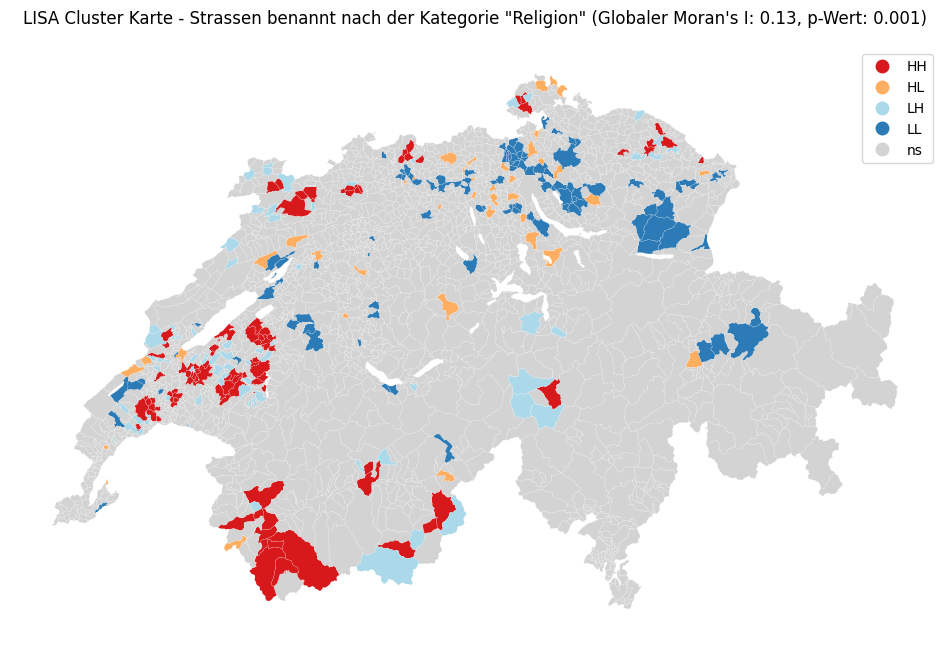

In [58]:
from splot.esda import lisa_cluster
from libpysal.weights.contiguity import Queen
from esda.moran import Moran_Local, Moran


trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].mean(), inplace = True)

#gdf = gdf[gdf.classif_y > 10]


#gdf.loc[gdf['classif_y'] < 10, 'percent_subset'] = gdf['percent_subset'].mean()

#gdf = communes_kategorie
w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.05, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Lebewesen')

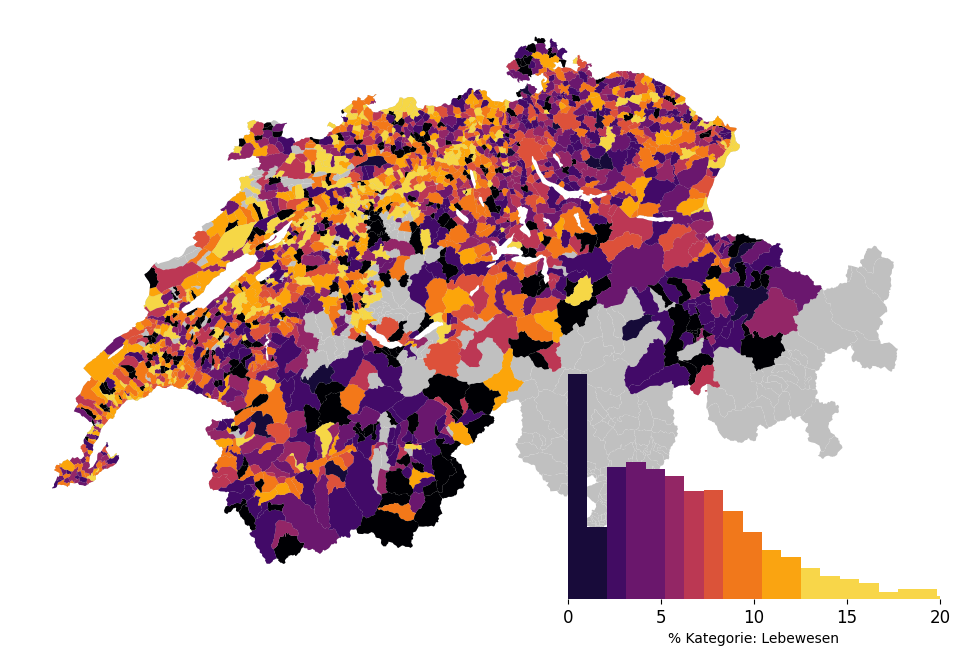

In [59]:
kategorie = 'Lebewesen'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=10
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_10,
           legend_size=(.4,.4), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,20) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

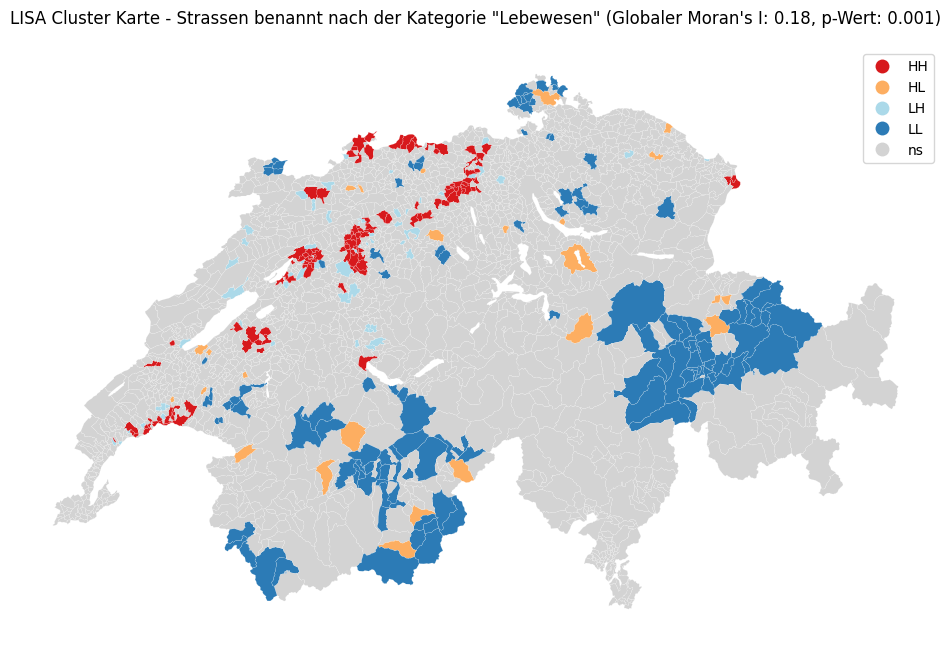

In [60]:
trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.05, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Natur')

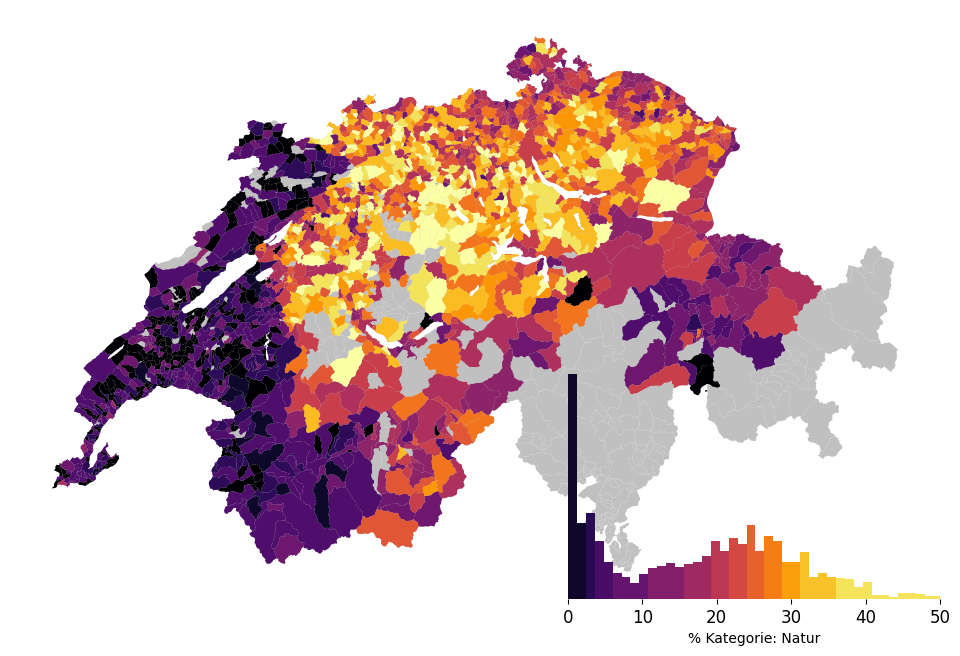

In [61]:
kategorie = 'Natur'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=14
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_14,
           legend_size=(.4,.4), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,50) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

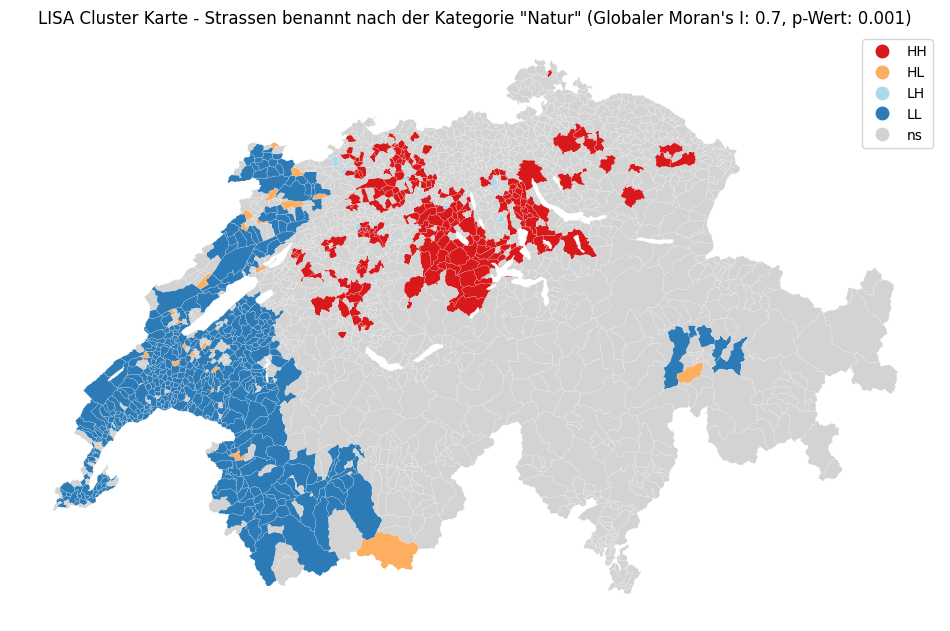

In [62]:
trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.01, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

Text(0.5, 0, '% Kategorie: Konnte nicht bestimmt werden')

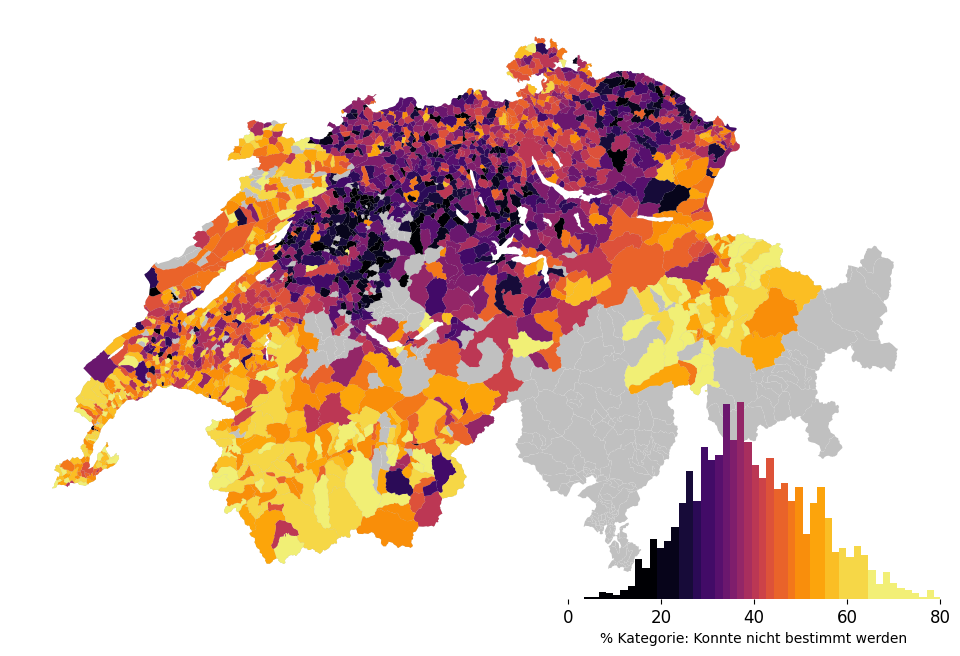

In [88]:
kategorie = 'Andere'

streetnames_s = pd.read_csv('../Modeling/out_mapping.csv', encoding='UTF-8-SIG', sep=';', low_memory=False)
subset = streetnames_s['classif'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["classif"] = subset["classif"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['classif'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.classif_x/kategorie_merge.classif_y*100)

communes_kategorie = pd.merge(communes_de_fr, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='left')
communes_kategorie = communes_kategorie.fillna(0)
communes_kategorie = communes_kategorie[communes_kategorie.classif_y > 10]

import palettable.matplotlib as palmpl
import mapclassify as mc

k=20
bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes.plot(figsize=(12,12),ax=ax, color = 'silver')
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.Quantiles(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_20,
           legend_size=(.4,.35), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,80) # clip the displayed range of the histogram
           )
kategorie = 'Konnte nicht bestimmt werden'
xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

In [64]:
trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.01, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

In [65]:
print(gdf[gdf['GMDNAME'].str.contains('Glarus')])

     FID_x  GMDHISTID  GMDNR      GMDNAME  BZHISTID  BZNR  KTNR  GRNR  \
649    649      15479   1630  Glarus Nord     10109   800     8     5   
650    650      15478   1631   Glarus Süd     10109   800     8     5   
651    651      15480   1632       Glarus     10109   800     8     5   

     AREA_HA  E_MIN_x  ...  AREA_HA_y   E_CNTR_y   N_CNTR_y  Z_CNTR_y  \
649    14700  2714690  ...    14700.0  2723200.0  1217800.0     436.0   
650    43003  2709274  ...    43003.0  2724300.0  1206100.0     537.0   
651    10367  2710559  ...    10367.0  2723700.0  1211300.0     475.0   

     GMD_STR_LENGTH  STR_TERMS   classif  classif_x  classif_y  percent_subset  
649      233.574842    strasse  Siedlung      194.0      424.0       45.754717  
650      230.676557    strasse     Natur      164.0      359.0       45.682451  
651      111.984463    strasse  Siedlung      104.0      252.0       41.269841  

[3 rows x 57 columns]


https://pysal.org/scipy2019-intermediate-gds/stochastic/gds5-exploration.html

https://pysal.org/scipy2019-intermediate-gds/stochastic/gds6-spatial-clusters.html

These types of local spatial autocorrelation describe similarities or dissimilarities between a specific 
polygon with its neighboring polygons. The upper left quadrant for example indicates that polygons with low 
values are surrounded by polygons with high values (LH). The lower right quadrant shows polygons with high 
values surrounded by neighbors with low values (HL). This indicates an association of dissimilar values.

Text(0.5, 0, '% Kategorie: strasse')

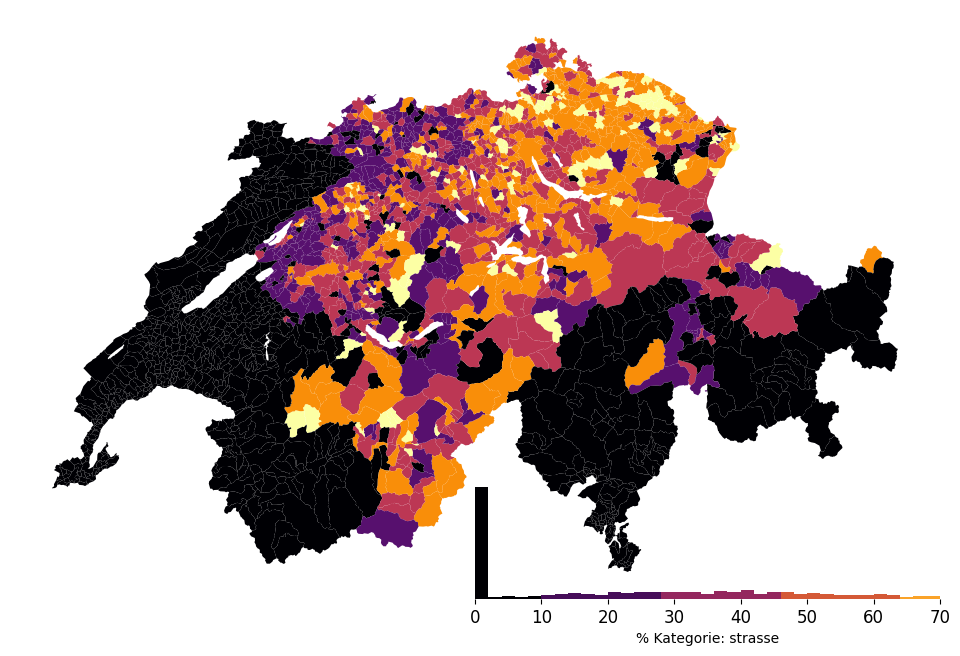

In [66]:
kategorie = 'strasse'

subset = streetnames_s['STN_LABEL_NO_BI'].str.contains(kategorie).groupby(streetnames_s['COM_FOSNR']).sum().to_frame()
subset["STN_LABEL_NO_BI"] = subset["STN_LABEL_NO_BI"].astype(int)

alle = streetnames_s.groupby(['COM_FOSNR'])['STN_LABEL_NO_BI'].agg(pd.Series.count).to_frame()

kategorie_merge = pd.merge(subset, alle, on='COM_FOSNR', how='outer')

kategorie_merge = kategorie_merge.assign(percent_subset = kategorie_merge.STN_LABEL_NO_BI_x/kategorie_merge.STN_LABEL_NO_BI_y*100)

communes_kategorie = pd.merge(communes, kategorie_merge, left_on='GMDNR', right_on='COM_FOSNR', how='outer')
communes_kategorie = communes_kategorie.fillna(0)

import palettable.matplotlib as palmpl
import mapclassify as mc

k=5
bins = mc.NaturalBreaks(communes_kategorie['percent_subset'].values, k=k).bins
bins = bins.astype(int).tolist()
bins = dict(bins=bins)
bins

f,ax = plt.subplots(1, figsize=(12,12))
communes_kategorie.plot('percent_subset', k=k, ax=ax, cmap='inferno', scheme="User_Defined",
                             classification_kwds=bins)

bins = mc.NaturalBreaks(communes_kategorie['percent_subset'].values, k=k).bins
ax.axis('off')

legendgram(f,ax,communes_kategorie['percent_subset'],bins,pal=palmpl.Inferno_5,
           legend_size=(.5,.2), # legend size in fractions of the axis
           loc='lower right', # matplotlib-style legend locations
           clip = (0,70) # clip the displayed range of the histogram
           )

xlabel = '% Kategorie: ' + kategorie
plt.xlabel(xlabel)

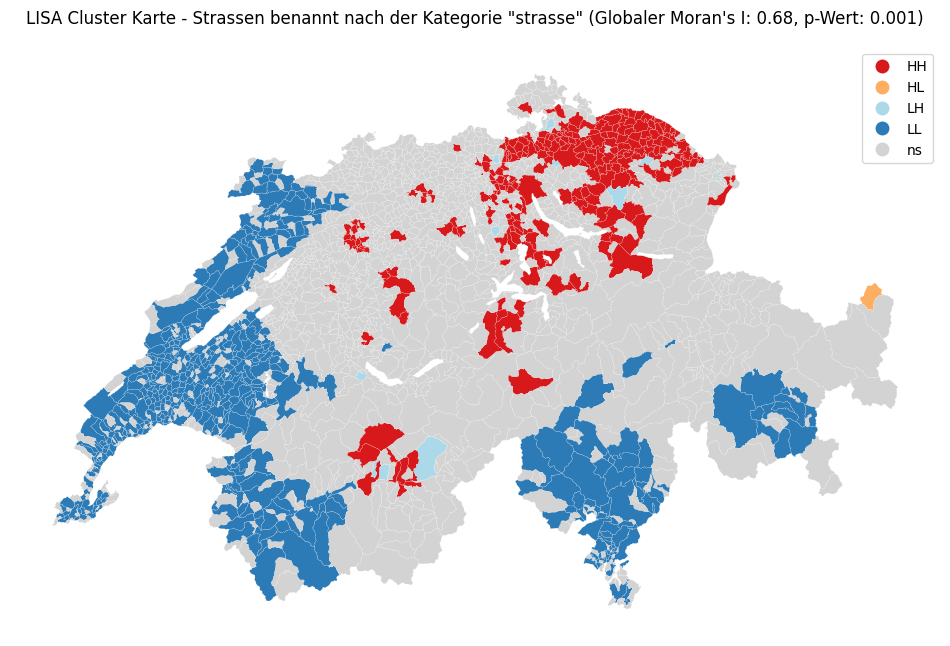

In [67]:
trans = communes_kategorie.drop(columns=['geometry'])
gdf = pd.merge(com_geom, trans, on=['GMDNR'], how='outer')
gdf['percent_subset'].fillna(value=gdf['percent_subset'].median(), inplace = True)

w = Queen.from_dataframe(gdf)
y = gdf['percent_subset'].values
moran = Moran(y, w)

moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, gdf, p=0.01, figsize = (12,12))
string = "LISA Cluster Karte - Strassen benannt nach der Kategorie \"" + str(kategorie) +'\" (Globaler Moran\'s I: ' + str(round(moran.I,2)) + ', p-Wert: '+ str(round(moran.p_sim,5)) + ')'
plt.title(string)
plt.show()

In [68]:
print(communes_kategorie[communes_kategorie['GMDNAME_x'].str.contains('Neuchâtel')])

       FID  GMDHISTID_x  GMDNR  GMDNAME_x  BZHISTID_x  BZNR_x  KTNR_x  GRNR_x  \
2043  2043        16604   6458  Neuchâtel       10320    2400      24       2   

      AREA_HA_x    E_MIN  ...  AREA_HA_y  E_CNTR_y  N_CNTR_y  Z_CNTR_y  \
2043       3008  2554853  ...       3008   2561300   1204700       438   

      GMD_STR_LENGTH  STR_TERMS  classif  STN_LABEL_NO_BI_x  \
2043      187.559438        rue   Person                0.0   

      STN_LABEL_NO_BI_y  percent_subset  
2043              390.0             0.0  

[1 rows x 37 columns]
